In [18]:
# ================== 1. 读数据 & 初步检查 ==================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 6 张交易表
pre_owned     = pd.read_csv("train/pre_owned_house_transactions.csv")
pre_owned_nb  = pd.read_csv("train/pre_owned_house_transactions_nearby_sectors.csv")
land          = pd.read_csv("train/land_transactions.csv")
land_nb       = pd.read_csv("train/land_transactions_nearby_sectors.csv")
new_house     = pd.read_csv("train/new_house_transactions.csv")
new_house_nb  = pd.read_csv("train/new_house_transactions_nearby_sectors.csv")

# 其他表
poi          = pd.read_csv("train/sector_POI.csv")
search_index = pd.read_csv("train/city_search_index.csv")
city_idx     = pd.read_csv("train/city_indexes.csv")

print("pre_owned.shape    =", pre_owned.shape)
print("pre_owned_nb.shape =", pre_owned_nb.shape)
print("land.shape         =", land.shape)
print("land_nb.shape      =", land_nb.shape)
print("new_house.shape    =", new_house.shape)
print("new_house_nb.shape =", new_house_nb.shape)
print("city_idx.shape     =", city_idx.shape)
print("poi.shape          =", poi.shape)
print("search_index.shape =", search_index.shape)


pre_owned.shape    = (5360, 6)
pre_owned_nb.shape = (5427, 6)
land.shape         = (5896, 6)
land_nb.shape      = (5025, 6)
new_house.shape    = (5433, 11)
new_house_nb.shape = (5360, 11)
city_idx.shape     = (7, 74)
poi.shape          = (86, 142)
search_index.shape = (4020, 4)


In [19]:
# ================== 2. 清洗 6 张交易表（保证 month+sector 唯一） ==================

def clean_tx(df: pd.DataFrame, name: str) -> pd.DataFrame:
    df = df.copy()
    # 去掉列名空格
    df.columns = [c.strip() for c in df.columns]
    
    # 检查 (month, sector) 是否唯一
    if not set(['month', 'sector']).issubset(df.columns):
        raise ValueError(f"[{name}] 缺少 month 或 sector 列，请检查原始 CSV 列名。")
    
    dup_mask = df.duplicated(subset=['month', 'sector'], keep=False)
    dup_count = dup_mask.sum()
    if dup_count > 0:
        print(f"[{name}] 在 (month, sector) 上有 {dup_count} 行重复，将按数值列求和聚合。")
        num_cols = df.select_dtypes(include='number').columns
        df = df.groupby(['month', 'sector'], as_index=False)[num_cols].sum()
    else:
        print(f"[{name}] 在 (month, sector) 上没有重复。")
    
    return df

pre_owned    = clean_tx(pre_owned,    "pre_owned")
pre_owned_nb = clean_tx(pre_owned_nb, "pre_owned_nb")
land         = clean_tx(land,         "land")
land_nb      = clean_tx(land_nb,      "land_nb")
new_house    = clean_tx(new_house,    "new_house")
new_house_nb = clean_tx(new_house_nb, "new_house_nb")


[pre_owned] 在 (month, sector) 上没有重复。
[pre_owned_nb] 在 (month, sector) 上没有重复。
[land] 在 (month, sector) 上没有重复。
[land_nb] 在 (month, sector) 上没有重复。
[new_house] 在 (month, sector) 上没有重复。
[new_house_nb] 在 (month, sector) 上没有重复。


In [20]:
# ================== 3. 构建 master：month×sector 网格 + 目标列 + 6 张交易表 ==================

# (1) 完整的 (month, sector) 主键网格
all_pairs = pd.concat([
    pre_owned[['month','sector']],
    pre_owned_nb[['month','sector']],
    land[['month','sector']],
    land_nb[['month','sector']],
    new_house[['month','sector']],
    new_house_nb[['month','sector']]
]).drop_duplicates().reset_index(drop=True)

print("all_pairs 行数：", len(all_pairs))
display(all_pairs.head())

# (2) 加上目标列 amount_new_house_transactions
if 'amount_new_house_transactions' not in new_house.columns:
    raise ValueError("new_house 表中没有 'amount_new_house_transactions' 列，请检查原始文件。")

master = all_pairs.merge(
    new_house[['month','sector','amount_new_house_transactions']],
    on=['month','sector'],
    how='left'
)

print("master 初始形状（只含目标列）:", master.shape)
print("master 中目标列缺失行数：",
      master['amount_new_house_transactions'].isna().sum())

# (3) 合并其他 5 张交易表（左连接）
# 注意：suffixes 防止同名列冲突，后续可以再精简列
master = master.merge(pre_owned,    on=['month', 'sector'], how='left', suffixes=('', '_pre'))
master = master.merge(pre_owned_nb, on=['month', 'sector'], how='left', suffixes=('', '_pre_nb'))
master = master.merge(land,         on=['month', 'sector'], how='left', suffixes=('', '_land'))
master = master.merge(land_nb,      on=['month', 'sector'], how='left', suffixes=('', '_land_nb'))
master = master.merge(new_house_nb, on=['month', 'sector'], how='left', suffixes=('', '_nh_nb'))

print("master 合并 6 张交易表后的形状：", master.shape)

# 再次检查 (month, sector) 唯一性
dup_master = master.duplicated(subset=['month', 'sector'], keep=False)
print("master 中 (month, sector) 重复行数：", dup_master.sum())


all_pairs 行数： 6432


,month,sector
0,2019-Jan,sector 35
1,2019-Jan,sector 23
2,2019-Jan,sector 80
3,2019-Jan,sector 53
4,2019-Jan,sector 84


master 初始形状（只含目标列）: (6432, 3)
master 中目标列缺失行数： 999
master 合并 6 张交易表后的形状： (6432, 28)
master 中 (month, sector) 重复行数： 0


In [21]:
# # ================== 4. 清洗 city_indexes，并展开成按月表 ==================

# city_idx = city_idx.copy()

# # 如果你确认最后一行是重复的 2022，可以删掉；否则注释掉下一行
# city_idx = city_idx.drop(city_idx.tail(1).index)

# # 去重
# city_idx = city_idx.drop_duplicates()

# # 删除全 NaN 的列
# city_idx = city_idx.loc[:, city_idx.notna().any(axis=0)]

# print("city_idx 清洗后形状：", city_idx.shape)
# display(city_idx.head())

# # 查看缺失情况（这里只是看看，不立即丢列）
# missing_counts_city_idx = city_idx.isna().sum()
# missing_counts_city_idx = missing_counts_city_idx[missing_counts_city_idx > 0].sort_values(ascending=False)
# print("city_idx 中有缺失的列：")
# display(missing_counts_city_idx)

# # 按年展开成每个月（YYYY-MMM），先不对缺失值做插值，保持原始信息
# if 'city_indicator_data_year' not in city_idx.columns:
#     raise ValueError("city_idx 中没有 'city_indicator_data_year' 列，请检查 city_indexes.csv。")

# city_idx_full = city_idx.copy()

# # 生成 YYYY-MMM 格式的 month（与交易表的 month 对齐）
# all_months = []
# for _, row in city_idx_full.iterrows():
#     year = int(row['city_indicator_data_year'])
#     for m in range(1, 13):
#         month_str = f"{year}-{pd.Timestamp(year, m, 1).strftime('%b')}"  # 例如 2017-Jan
#         data = row.drop(labels=['city_indicator_data_year']).to_dict()
#         data['month'] = month_str
#         all_months.append(data)

# city_idx_month = pd.DataFrame(all_months)

# print("city_idx_month 形状：", city_idx_month.shape)
# display(city_idx_month.head())


In [22]:
# ================== 5. 合并 city 指标到 master，生成 df ==================

# 先把 month 保持为字符串（后面统一转为 datetime）
master = master.copy()

# # 合并 city_idx_month：同一年的指标复制到该年的每个月
# master = master.merge(city_idx_month, on='month', how='left', suffixes=('', '_idx'))
# print("合并 city_idx_month 后 master 形状：", master.shape)

# # （可选）合并 search_index，如果它有 month 列
# if 'month' in search_index.columns:
#     master = master.merge(search_index, on='month', how='left', suffixes=('', '_search'))
#     print("合并 search_index 后 master 形状：", master.shape)
# else:
#     print("search_index 中没有 month 列，暂时跳过合并。")

# # （可选）合并 poi，如果它按 sector 静态给指标
# if 'sector' in poi.columns:
#     master = master.merge(poi, on='sector', how='left', suffixes=('', '_poi'))
#     print("合并 poi 后 master 形状：", master.shape)
# else:
#     print("poi 中没有 sector 列，暂时跳过合并。")

# 建模主表
df = master.copy()
print("df 初始形状：", df.shape)


df 初始形状： (6432, 28)


类型统一 & 去重后的 df 形状： (6432, 28)


,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,transaction_amount_nearby_sectors,num_new_house_transactions_nearby_sectors,area_new_house_transactions_nearby_sectors,price_new_house_transactions_nearby_sectors,amount_new_house_transactions_nearby_sectors,area_per_unit_new_house_transactions_nearby_sectors,total_price_per_unit_new_house_transactions_nearby_sectors,num_new_house_available_for_sale_nearby_sectors,area_new_house_available_for_sale_nearby_sectors,period_new_house_sell_through_nearby_sectors
0,2019-01-01,1,13827.14,9163.0,40994.7,111.0,44739.38666,6.750000,733.000000,1247.03800,...,0.0,29.444444,3532.444444,51992.52013,18366.06889,119.969811,623.753283,350.250000,49809.8750,29.696250
1,2019-01-01,2,28277.73,192.0,315.0,2.0,16406.25000,64.181818,5339.000000,20880.24282,...,0.0,51.000000,5830.500000,18152.22108,10583.65250,114.323529,207.522598,1366.666667,170501.0000,17.093333
2,2019-01-01,3,NaN,NaN,NaN,NaN,NaN,77.714286,7457.142857,17376.21486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,4,1424.21,0.0,0.0,0.0,12794.68999,57.666667,5109.666667,19021.15267,...,0.0,106.666667,10736.333330,21105.52175,22659.59167,100.653125,212.433672,2045.333333,238398.8333,29.178333
4,2019-01-01,5,792.10,NaN,NaN,NaN,NaN,45.428571,3763.500000,15800.74143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


df 中缺失值列统计（只显示有缺失的列）：


transaction_amount_nearby_sectors                             1407
num_land_transactions_nearby_sectors                          1407
construction_area_nearby_sectors                              1407
planned_building_area_nearby_sectors                          1407
price_pre_owned_house_transactions                            1086
num_new_house_transactions_nearby_sectors                     1072
num_pre_owned_house_transactions                              1072
amount_pre_owned_house_transactions                           1072
amount_new_house_transactions_nearby_sectors                  1072
area_pre_owned_house_transactions                             1072
total_price_per_unit_new_house_transactions_nearby_sectors    1072
num_new_house_available_for_sale_nearby_sectors               1072
area_new_house_available_for_sale_nearby_sectors              1072
area_per_unit_new_house_transactions_nearby_sectors           1072
period_new_house_sell_through_nearby_sectors                  

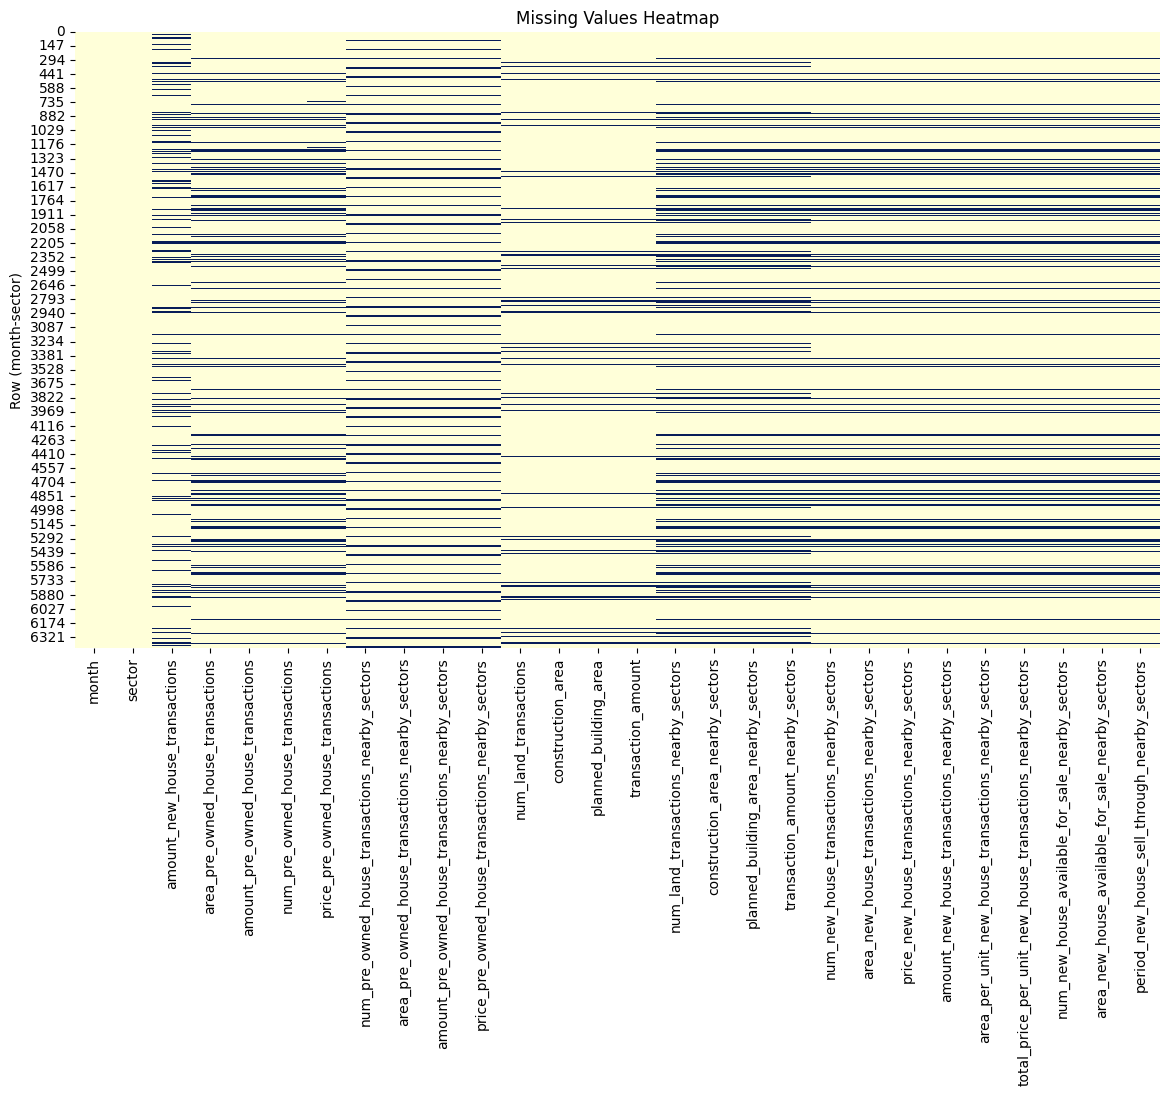

In [23]:
# ================== 6. 统一类型、去重、检查缺失 ==================

# 1) month 转为 datetime（只保留年月）
# 如果 month 已经是 datetime，可适当调整 format
df['month'] = pd.to_datetime(df['month'], format='%Y-%b')

# 2) sector：如果是 'sector 1' 形式，提取数字
if df['sector'].dtype == 'object':
    df['sector'] = df['sector'].str.extract(r'(\d+)').astype(int)

# 3) 按 (month, sector) 排序
df = df.sort_values(['month', 'sector']).reset_index(drop=True)

# 4) 删除重复行
df = df.drop_duplicates()

# 5) 删除完全重复的列
df = df.loc[:, ~df.T.duplicated()]

print("类型统一 & 去重后的 df 形状：", df.shape)
display(df.head())

# 缺失总体情况
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("df 中缺失值列统计（只显示有缺失的列）：")
display(missing_counts)

# 缺失热力图（可以留在单独一个 cell）
plt.figure(figsize=(14, 8))
sns.heatmap(df.isna(), cbar=False, cmap="YlGnBu")
plt.ylabel("Row (month-sector)")
plt.title("Missing Values Heatmap")
plt.show()


In [24]:
# ================== 7. 按类型处理缺失值（不再全表 ffill，不动目标列之外的逻辑） ==================

import numpy as np

target_col = "amount_new_house_transactions"

# 1) 宏观时间序列类特征：来自 city_idx / search_index
macro_cols = [c for c in df.columns 
              if c.startswith("city_") or c.startswith("search_")]

# 2) 计数 / 金额 / 面积类特征：num_ / amount_ / area_ 开头（除目标以外）
count_cols = [c for c in df.columns 
              if (("num_" in c) or ("amount_" in c) or ("area_" in c))]
count_cols = [c for c in count_cols if c != target_col]

# 3) 其他数值特征（剔除上面这些）
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
other_num_cols = [
    c for c in num_cols_all
    if (c not in count_cols) and (c != target_col)
]

# 先保证时间 + 板块排序正确（非常重要，后面 rolling/shift 要用）
df = df.sort_values(["sector", "month"]).reset_index(drop=True)

# --- 宏观时间序列：按时间前后填充 ---
for col in macro_cols:
    df[col] = df[col].ffill().bfill()

# --- 计数 / 金额 / 面积类：缺失视为 0（没有交易 / 没有库存） ---
if count_cols:
    df[count_cols] = df[count_cols].fillna(0)

# --- 其他数值：用列中位数填充 ---
if other_num_cols:
    df[other_num_cols] = df[other_num_cols].fillna(df[other_num_cols].median())

# --- 目标列：你要么把缺失行直接删掉，要么视为 0 ---
# 这里我暂时采用“缺失 = 0（无成交）”，如果你不认可，可以改成：
# df = df[~df[target_col].isna()]
df[target_col] = df[target_col].fillna(0)

print("预处理（含缺失值处理）后的 df 形状：", df.shape)
df.info()


预处理（含缺失值处理）后的 df 形状： (6432, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6432 entries, 0 to 6431
Data columns (total 28 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   month                                                       6432 non-null   datetime64[ns]
 1   sector                                                      6432 non-null   int64         
 2   amount_new_house_transactions                               6432 non-null   float64       
 3   area_pre_owned_house_transactions                           6432 non-null   float64       
 4   amount_pre_owned_house_transactions                         6432 non-null   float64       
 5   num_pre_owned_house_transactions                            6432 non-null   float64       
 6   price_pre_owned_house_transactions                          6432 non-null   float64     

In [25]:
# 上面是Preprocessing, 下面是特征工程

In [26]:
# ================== 8. 时间 & 宏观周期特征 ==================

# 再次确保排序：sector 内按时间
df = df.sort_values(["sector", "month"]).reset_index(drop=True)

# 连续时间索引：2014-01 -> 0, 2014-02 -> 1, ...
year0 = df["month"].dt.year.min()
df["t"] = (df["month"].dt.year - year0) * 12 + (df["month"].dt.month - 1)
df["t2"] = df["t"] ** 2  # 简单的非线性趋势

# 宏观指标的趋势 / 周期位置
# 延续上面 macro_cols 的定义（city_*, search_*）
for col in macro_cols:
    # 与前一年的同比增速
    df[f"{col}_yoy"] = df.groupby("sector")[col].transform(
        lambda s: (s - s.shift(12)) / (s.shift(12) + 1e-6)
    )
    
    # 过去 12 个月的平均（长期景气度）
    df[f"{col}_ma12"] = df.groupby("sector")[col].transform(
        lambda s: s.rolling(12, min_periods=6).mean()
    )
    
    # 当前值相对于长期均值的偏离（处在周期的高位还是低位）
    df[f"{col}_gap_ma12"] = df[col] / (df[f"{col}_ma12"] + 1e-6) - 1

# 这里用的逻辑完全不提“季节”，而是：

# t, t2 → 长期时间趋势；

# *_yoy → 当前处于上行/下行周期；

# *_ma12 和 *_gap_ma12 → 当前比长期均值高还是低。

# 这和你“更看重经济周期而不是季节性”的直觉是一致的。

In [27]:
# ================== 9. 供需状态特征 ==================

# (1) 每套房的平均面积 / 金额
if {"area_new_house_transactions", "num_new_house_transactions"}.issubset(df.columns):
    df["avg_area_per_unit"] = df["area_new_house_transactions"] / (df["num_new_house_transactions"] + 1e-6)
if {"amount_new_house_transactions", "num_new_house_transactions"}.issubset(df.columns):
    df["avg_amount_per_unit"] = df["amount_new_house_transactions"] / (df["num_new_house_transactions"] + 1e-6)

# (2) 存销比 / 库存压力
if {"num_new_house_available_for_sale", "num_new_house_transactions"}.issubset(df.columns):
    df["inventory_per_unit"] = df["num_new_house_available_for_sale"] / (df["num_new_house_transactions"] + 1e-6)
if {"area_new_house_available_for_sale", "area_new_house_transactions"}.issubset(df.columns):
    df["inventory_per_area"] = df["area_new_house_available_for_sale"] / (df["area_new_house_transactions"] + 1e-6)

# (3) 去化周期平滑
if "period_new_house_sell_through" in df.columns:
    df["sell_through_ma6"] = df.groupby("sector")["period_new_house_sell_through"].transform(
        lambda s: s.rolling(6, min_periods=3).mean()
    )

# (4) 自身历史的长期均值 + 当前偏离
key_cols_raw = [
    "amount_new_house_transactions",
    "num_new_house_transactions",
    "price_new_house_transactions",
]
key_cols = [c for c in key_cols_raw if c in df.columns]

for col in key_cols:
    # 过去 12 个月平均（长期水平）
    df[f"{col}_ma12"] = df.groupby("sector")[col].transform(
        lambda s: s.rolling(12, min_periods=6).mean()
    )
    df[f"{col}_gap_ma12"] = df[col] / (df[f"{col}_ma12"] + 1e-6) - 1

    # 过去 3 个月平均（短期状态）
    df[f"{col}_ma3"] = df.groupby("sector")[col].transform(
        lambda s: s.rolling(3, min_periods=2).mean()
    )
    df[f"{col}_gap_ma3"] = df[col] / (df[f"{col}_ma3"] + 1e-6) - 1

# 这样你就有：

# inventory_per_unit / inventory_per_area → 市场冷暖；

# *_ma12 / *_gap_ma12 → 板块长期水平 & 当前偏离；

# *_ma3 / *_gap_ma3 → 短期波动。

In [28]:
# ================== 10. 区位结构特征 ==================

# (1) sector 固定效应（one-hot）
sector_dummies = pd.get_dummies(df["sector"], prefix="sector")
df = pd.concat([df, sector_dummies], axis=1)

# (2) 相对全市的“份额 / 溢价”
#   注意这里的 groupby 不再用 year，而是直接按 month（datetime）来聚合同一月份的所有板块
if "amount_new_house_transactions" in df.columns:
    df["city_amount_total"] = df.groupby("month")["amount_new_house_transactions"].transform("sum")
    df["sector_amount_share"] = df["amount_new_house_transactions"] / (df["city_amount_total"] + 1e-6)

if "price_new_house_transactions" in df.columns:
    df["city_price_avg"] = df.groupby("month")["price_new_house_transactions"].transform("mean")
    df["sector_price_premium"] = df["price_new_house_transactions"] / (df["city_price_avg"] + 1e-6) - 1


In [29]:
# ================== 11. 最后检查 ==================
print("最终 df 形状：", df.shape)
print("\n部分列预览：")
cols_preview = [
    "month", "sector",
    "amount_new_house_transactions",
    "t", "t2",
] + [c for c in df.columns if c.endswith("_yoy")][:3] \
  + [c for c in df.columns if c.endswith("_gap_ma12")][:3] \
  + ["inventory_per_unit" if "inventory_per_unit" in df.columns else None,
     "sector_amount_share" if "sector_amount_share" in df.columns else None,
     "sector_price_premium" if "sector_price_premium" in df.columns else None]

cols_preview = [c for c in cols_preview if c is not None and c in df.columns]
display(df[cols_preview].head(30))


最终 df 形状： (6432, 132)

部分列预览：


,month,sector,amount_new_house_transactions,t,t2,amount_new_house_transactions_gap_ma12,sector_amount_share
0,2019-01-01,1,13827.14,0,0,NaN,0.008552
1,2019-02-01,1,8802.81,1,1,NaN,0.008605
2,2019-03-01,1,23283.48,2,4,NaN,0.008315
3,2019-04-01,1,26626.68,3,9,NaN,0.011491
4,2019-05-01,1,8649.42,4,16,NaN,0.003845
5,2019-06-01,1,20116.16,5,25,0.191413,0.008052
6,2019-07-01,1,14325.33,6,36,-0.132782,0.006571
7,2019-08-01,1,29794.76,7,49,0.639036,0.013713
8,2019-09-01,1,13982.09,8,64,-0.210586,0.006267
9,2019-10-01,1,11949.09,9,81,-0.302678,0.006418


In [30]:
dup_counts = df.groupby(["month", "sector"]).size()
print(dup_counts.value_counts().head(10))


1    6432
Name: count, dtype: int64


In [31]:
df[(df["month"] == pd.Timestamp("2019-01-01")) & (df["sector"] == 1)]

,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,sector_89,sector_90,sector_91,sector_92,sector_93,sector_94,sector_95,sector_96,city_amount_total,sector_amount_share
0,2019-01-01,1,13827.14,9163.0,40994.7,111.0,44739.38666,6.75,733.0,1247.038,...,False,False,False,False,False,False,False,False,1616823.8,0.008552
